# Prediction of the electrical consumption needs of buildings

# Content
- [Unpickling the cleaned and filtered data for prediction analysis](#Unpickling-the-cleaned-and-filtered-data-for-prediction-analysis)
- [Prediction analysis](#Prediction-analysis)

In [568]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Use seaborn style defaults and set the default figure size
import seaborn as sns
sns.set(rc={'figure.figsize':(11, 6)})

## Unpickling the cleaned and filtered data for prediction analysis

After we pickled the data frame with the cleaned and filtered data, we have to unpickle such data frame.

In [569]:
# To pickle the data frame

new_df_both_years = pd.read_pickle("./pickle_data_cleaned.pkl")

### Correlation analysis

We will calculate the pairwise correlation between columns and return a correlation matrix. We used the corr() function with the Kendall correlation coefficient, which measures the monotonic relationship between two variables. It does not require the variables to be normally distributed. (See reference https://www.learnpythonwithrune.org/pandas-correlation-methods-explained-pearson-kendall-and-spearman/)

In [570]:
correlation_matrix = new_df_both_years.corr(method='kendall')

In [571]:
print(correlation_matrix)

                        OSEBuildingID  DataYear  Latitude  Longitude  \
OSEBuildingID                1.000000  0.013631 -0.010742   0.098695   
DataYear                     0.013631  1.000000  0.000172   0.004860   
Latitude                    -0.010742  0.000172  1.000000  -0.137762   
Longitude                    0.098695  0.004860 -0.137762   1.000000   
YearBuilt                   -0.050521  0.008015  0.057468   0.000817   
ENERGYSTARScore             -0.032602  0.021516  0.020162  -0.027588   
SiteEUI(kBtu/sf)            -0.056249  0.003906  0.097419  -0.023261   
SourceEUI(kBtu/sf)          -0.076408 -0.002932  0.096200  -0.036237   
SiteEnergyUse(kBtu)         -0.276636  0.000130  0.049795  -0.031697   
NumberofBuildings           -0.015511 -0.017740  0.005241   0.037821   
NumberofFloors              -0.237381 -0.006939  0.093091  -0.071321   
PropertyGFATotal            -0.384319 -0.002192  0.001796  -0.042957   
PropertyGFABuilding(s)      -0.386369 -0.003135 -0.019871  -0.03

<AxesSubplot:>

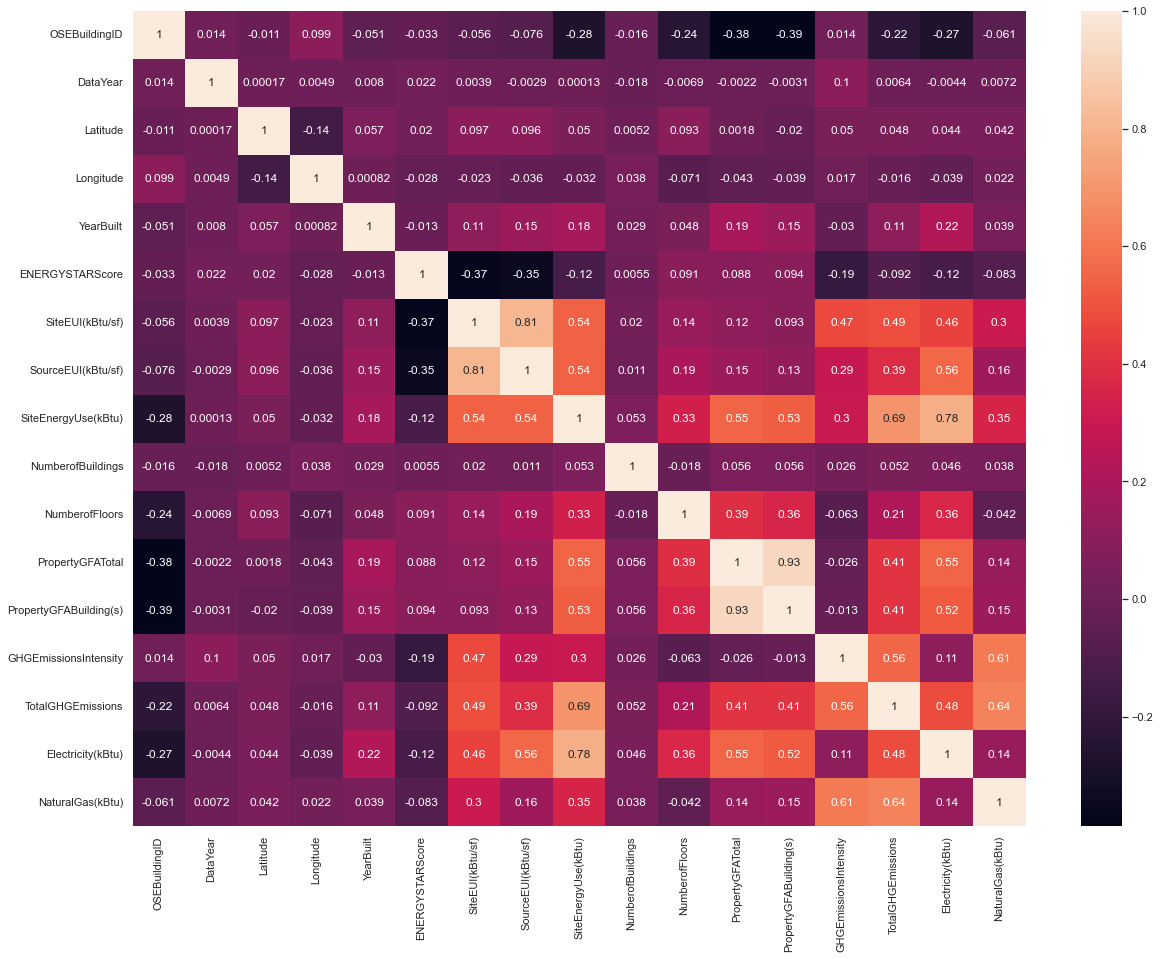

In [572]:
plt.figure(figsize=(20,15))
sns.heatmap(correlation_matrix, xticklabels=correlation_matrix.columns, yticklabels=correlation_matrix.columns, annot=True)

The correlation matrix allows us to identify correlations between pairs of variables as we will see next.

In [573]:
# See reference code at https://www.kaggle.com/marcbourgeois/p-lec-01-cleaning

threshold = 0.8
correlation_pairs = correlation_matrix.unstack().sort_values(kind="quicksort")
strong_corr = (pd.DataFrame(correlation_pairs[(abs(correlation_pairs) > threshold)]).reset_index().rename(columns={0:'Correlation coefficients'}))
strong_corr = strong_corr[(strong_corr.index%2 == 0) & (strong_corr['level_0'] != strong_corr['level_1'])]
strong_corr.sort_values('Correlation coefficients', ascending=False)

,level_0,level_1,Correlation coefficients
2,PropertyGFATotal,PropertyGFABuilding(s),0.927988
0,SourceEUI(kBtu/sf),SiteEUI(kBtu/sf),0.809493


Correlation Coefficient = +1: A perfect positive relationship. 

Correlation Coefficient >= 0.8: A fairly strong positive relationship.

### Preparation of variables for prediction analysis with different algorithms

In [574]:
new_df_both_years.columns 

Index(['OSEBuildingID', 'DataYear', 'BuildingType', 'PrimaryPropertyType',
       'Latitude', 'Longitude', 'Address', 'Neighborhood', 'YearBuilt',
       'ENERGYSTARScore', 'SiteEUI(kBtu/sf)', 'SourceEUI(kBtu/sf)',
       'SiteEnergyUse(kBtu)', 'NumberofBuildings', 'NumberofFloors',
       'PropertyGFATotal', 'PropertyGFABuilding(s)', 'GHGEmissionsIntensity',
       'TotalGHGEmissions', 'Electricity(kBtu)', 'NaturalGas(kBtu)'],
      dtype='object')

In the next cell we will make the final selection of variables to create the input data for the model predictions.

In [575]:
subset_columns_for_analysis = [
                                # 'OSEBuildingID', # ID not needed
                                # 'DataYear', # Refered as 2015 or 2016
                                # 'BuildingType', # Residential or Non-residential (not needed)
                                'PrimaryPropertyType',
                                # 'Latitude', 'Longitude', 'Address', # Physical address and coordinates not needed
                                'Neighborhood', 
                                'YearBuilt', 
                                # 'ENERGYSTARScore', # More than 20% percent of missing data
                                # 'SiteEUI(kBtu/sf)', # Property's Site Energy Use divided by its gross floor area. Related to the target variable 'SiteEnergyUse(kBtu)'
                                # 'SourceEUI(kBtu/sf)', # Highly correlated to 'SiteEUI(kBtu/sf)' (0.81)
                                'SiteEnergyUse(kBtu)',
                                'NumberofBuildings', 
                                'NumberofFloors', 
                                'PropertyGFATotal',
                                # 'PropertyGFABuilding(s)', # Highly correlated to 'PropertyGFATotal' (0.93)
                                # 'GHGEmissionsIntensity', # Greenhouse Gas Emissions divided by property's gross floor area. Related to the target variable 'TotalGHGEmissions' 
                                'TotalGHGEmissions', 
                                'Electricity(kBtu)',
                                'NaturalGas(kBtu)'
                            ]

**Although the terms 'electricity' and 'energy' are often used interchangeably, it's important to understand that electricity is just one component of total energy consumption.**

In [576]:
subset_data_frame_for_analysis = new_df_both_years.copy()

In [577]:
new_data_frame_for_analysis = subset_data_frame_for_analysis[subset_columns_for_analysis]

In [578]:
new_data_frame_for_analysis.head()

,PrimaryPropertyType,Neighborhood,YearBuilt,SiteEnergyUse(kBtu),NumberofBuildings,NumberofFloors,PropertyGFATotal,TotalGHGEmissions,Electricity(kBtu),NaturalGas(kBtu)
0,Hotel,DOWNTOWN,1927,6981428.0,1.0,12.0,88434,249.43,3686160.0,1272388.0
1,Hotel,DOWNTOWN,1996,8354235.0,1.0,11.0,103566,263.51,3905411.0,4448985.0
2,Hotel,DOWNTOWN,1969,73130656.0,1.0,41.0,961990,2061.48,49762435.0,3709900.0
3,Hotel,DOWNTOWN,1926,28229320.0,1.0,10.0,61320,1936.34,2769023.0,2001894.0
4,Hotel,DOWNTOWN,1980,14829099.0,1.0,18.0,119890,507.70,6066245.0,8763105.0


In [579]:
categorical_columns = ['PrimaryPropertyType', 'Neighborhood', 'BuildingType']

for i in new_data_frame_for_analysis.columns:
    if i not in categorical_columns:
        new_data_frame_for_analysis[i].fillna(new_data_frame_for_analysis[i].median(),inplace=True)

    else:
        new_data_frame_for_analysis[i].fillna('Unknown',inplace=True)

C:\Users\ASUS\anaconda3\lib\site-packages\pandas\core\generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [580]:
new_data_frame_for_analysis = new_data_frame_for_analysis.astype({'PrimaryPropertyType': 'category', 'Neighborhood': 'category'})

In [581]:
columns_to_categorical = new_data_frame_for_analysis.select_dtypes(['category']).columns

In [582]:
new_data_frame_for_analysis[columns_to_categorical] = new_data_frame_for_analysis[columns_to_categorical].apply(lambda x: x.cat.codes)

In [583]:
print("The data frame with analysis variables contains {} rows and {} columns".format(new_data_frame_for_analysis.shape[0],new_data_frame_for_analysis.shape[1]))

The data frame with analysis variables contains 3264 rows and 10 columns


In [584]:
new_data_frame_for_analysis.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3264 entries, 0 to 6715
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   PrimaryPropertyType  3264 non-null   int8   
 1   Neighborhood         3264 non-null   int8   
 2   YearBuilt            3264 non-null   int64  
 3   SiteEnergyUse(kBtu)  3264 non-null   float64
 4   NumberofBuildings    3264 non-null   float64
 5   NumberofFloors       3264 non-null   float64
 6   PropertyGFATotal     3264 non-null   int64  
 7   TotalGHGEmissions    3264 non-null   float64
 8   Electricity(kBtu)    3264 non-null   float64
 9   NaturalGas(kBtu)     3264 non-null   float64
dtypes: float64(6), int64(2), int8(2)
memory usage: 235.9 KB


### Feature transformation

We are going to use logaritmic transformation to normalize our data. See references: 

* https://www.analyticsvidhya.com/blog/2020/07/types-of-feature-transformation-and-scaling/
* https://www.mygreatlearning.com/blog/outlier-analysis-explained/
* https://www.codecademy.com/article/normalization
* https://jamesmccaffrey.wordpress.com/2020/05/27/should-you-normalize-and-encode-data-before-train-test-splitting-or-after-splitting/

In [587]:
df_log_transformed = new_data_frame_for_analysis.copy()

In [588]:
for col in df_log_transformed.columns:
    df_log_transformed[col] = np.log(df_log_transformed[col] + 0.1) 

In [590]:
df_log_transformed.describe()

,PrimaryPropertyType,Neighborhood,YearBuilt,SiteEnergyUse(kBtu),NumberofBuildings,NumberofFloors,PropertyGFATotal,TotalGHGEmissions,Electricity(kBtu),NaturalGas(kBtu)
count,3264.000000,3264.000000,3264.000000,3264.000000,3264.000000,3264.000000,3264.000000,3264.000000,3264.000000,3264.000000
mean,2.394513,1.443595,7.581435,14.813845,0.087921,0.990419,11.050199,3.923051,14.386475,9.109910
std,0.766939,0.941150,0.016692,1.836904,0.383589,0.846987,0.950090,1.550449,1.792739,7.323565
min,-2.302585,-2.302585,7.549662,-2.302585,-2.302585,-2.302585,9.331239,-2.302585,-2.302585,-2.302585
25%,1.960095,1.131402,7.565327,14.016755,0.095310,0.095310,10.296706,2.986439,13.494646,-2.302585
50%,2.493205,1.629241,7.583298,14.739285,0.095310,0.741937,10.813360,3.895995,14.306878,13.080133
75%,3.049273,1.960095,7.595438,15.760986,0.095310,1.410987,11.562390,4.937706,15.408919,14.208402
max,3.261935,2.493205,7.608424,20.588504,4.710431,4.596129,16.047690,9.733356,20.303308,19.512299


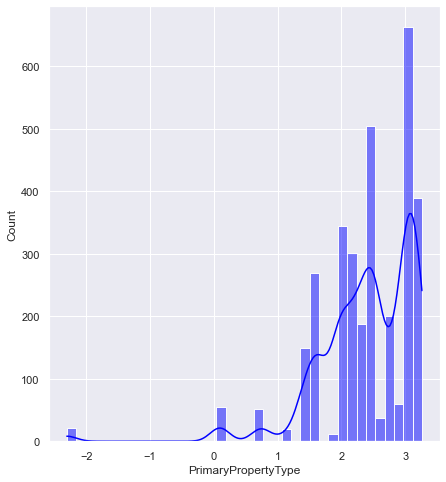

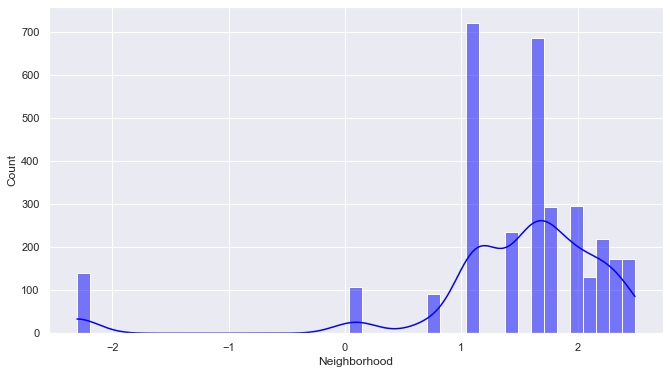

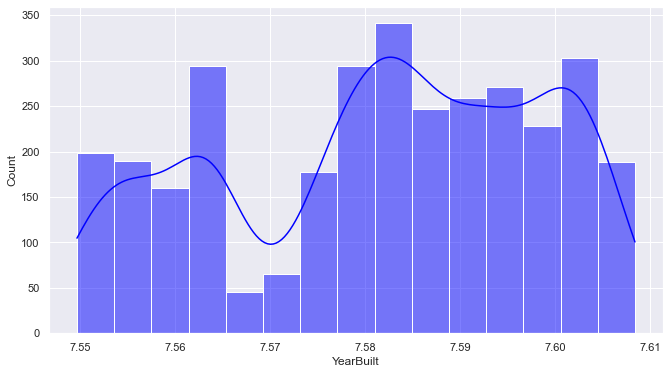

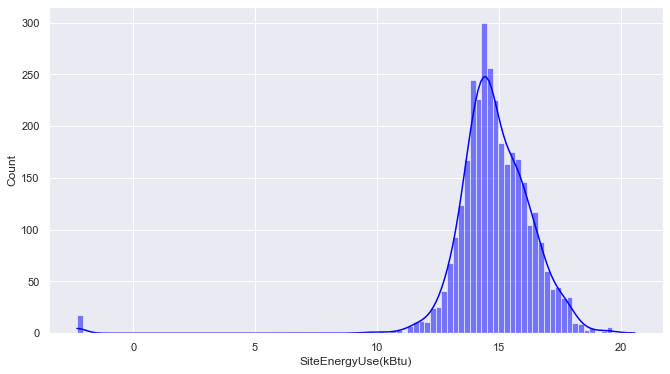

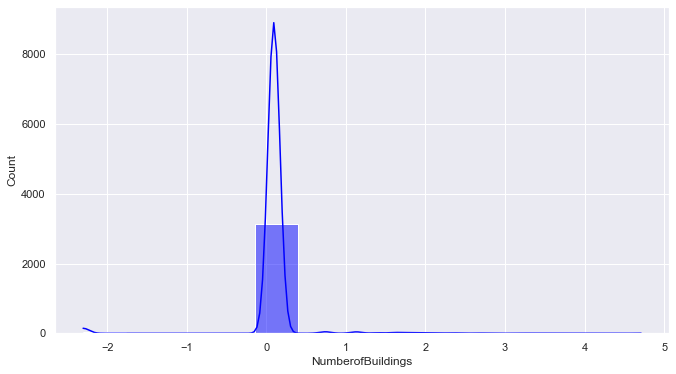

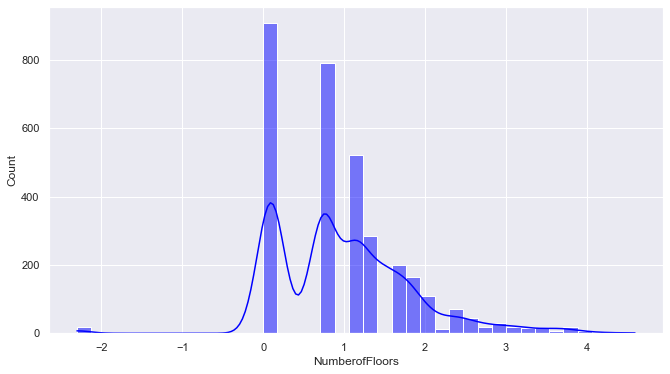

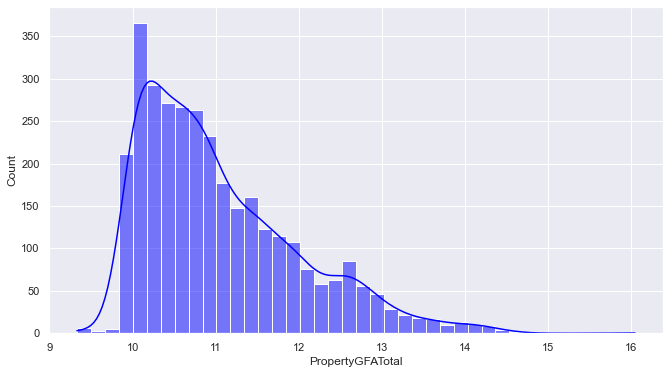

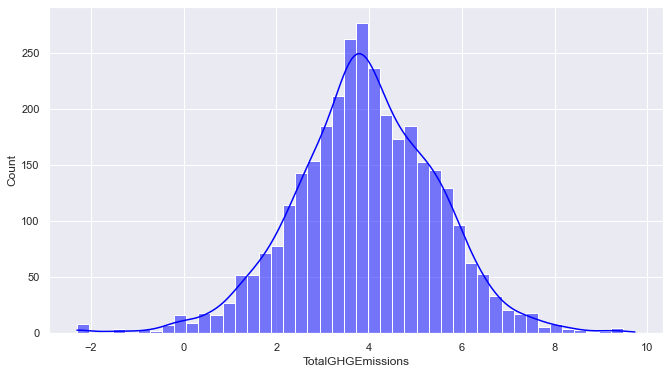

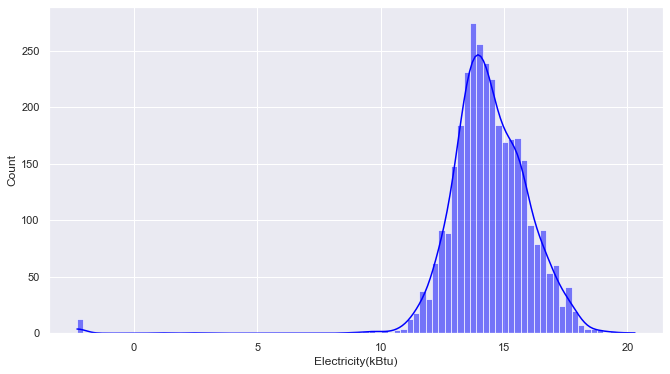

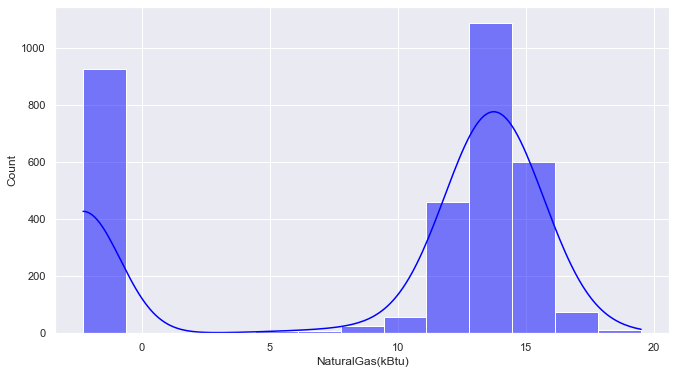

In [591]:
df_log_transformed.describe()
plt.subplots(figsize=(7, 8))
for i in df_log_transformed.columns:
    sns.histplot(data=df_log_transformed, x=i, color="blue", kde=True)
    plt.show()

In [592]:
print("Standardized data frame contains {} rows and {} columns".format(df_log_transformed.shape[0], df_log_transformed.shape[1]))

Standardized data frame contains 3264 rows and 10 columns


In [637]:
# df_log_transformed_without_outliers = df_log_transformed.loc[
#                                                     (df_log_transformed['NumberofBuildings'] >= -3*(df_log_transformed['NumberofBuildings'].std())) & (df_log_transformed['NumberofBuildings'] <= 3*(df_log_transformed['NumberofBuildings'].std()))
#                                                     & (df_log_transformed['SiteEnergyUse(kBtu)'] >= -3*(df_log_transformed['SiteEnergyUse(kBtu)'].std())) & (df_log_transformed['SiteEnergyUse(kBtu)'] <= 3*(df_log_transformed['SiteEnergyUse(kBtu)'].std()))
#                                                     & (df_log_transformed['NumberofFloors'] >= -3*(df_log_transformed['NumberofFloors'].std())) & (df_log_transformed['NumberofFloors'] <= 3*(df_log_transformed['NumberofFloors'].std()))
#                                                     & (df_log_transformed['PropertyGFATotal'] >= -3*(df_log_transformed['PropertyGFATotal'].std())) & (df_log_transformed['PropertyGFATotal'] <= 3*(df_log_transformed['PropertyGFATotal'].std()))
#                                                     & (df_log_transformed['Electricity(kBtu)'] >= -3*(df_log_transformed['Electricity(kBtu)'].std())) & (df_log_transformed['Electricity(kBtu)'] <= 2*(df_log_transformed['Electricity(kBtu)'].std()))
#                                                     & (df_log_transformed['TotalGHGEmissions'] >= -3*(df_log_transformed['TotalGHGEmissions'].std())) & (df_log_transformed['TotalGHGEmissions'] <= 3*(df_log_transformed['TotalGHGEmissions'].std()))
#                                                     & (df_log_transformed['NaturalGas(kBtu)'] >= -3*(df_log_transformed['NaturalGas(kBtu)'].std())) & (df_log_transformed['NaturalGas(kBtu)'] <= 3*(df_log_transformed['NaturalGas(kBtu)'].std()))
#                                                     ]

In [638]:
# plt.subplots(figsize=(7, 8))
# for i in df_log_transformed_without_outliers.columns:
#     sns.histplot(data = df_log_transformed_without_outliers, x=i, color="blue")
#     plt.show()

In [595]:
print("Standardized data frame without outliers contains {} rows and {} columns".format(df_log_transformed.shape[0], df_log_transformed.shape[1]))

Standardized data frame without outliers contains 3264 rows and 10 columns


## Prediction analysis

### Data splitting for training and test

#### Prediction of Green House Gas Emissions to evaluate models performance

In [596]:
from sklearn.model_selection import train_test_split

In [597]:
def get_training_and_testing_data(data_frame, target_column):
    columns_to_remove_from_explicative_variables = ['TotalGHGEmissions', 'SiteEnergyUse(kBtu)']
    training_data, testing_data = train_test_split(data_frame, test_size=0.2, random_state=25) # Here we use 80% for traning and 20% for test
    X_training_data = training_data.drop(columns = columns_to_remove_from_explicative_variables)
    y_training_data = training_data[target_column]
    X_testing_data = testing_data.drop(columns = columns_to_remove_from_explicative_variables)
    y_testing_data = testing_data[target_column]

    return(X_training_data, y_training_data, X_testing_data, y_testing_data)

In [598]:
X_training, y_training, X_test, y_test = get_training_and_testing_data(df_log_transformed, 'TotalGHGEmissions')

In [599]:
print(f"No. of training examples: {X_training.shape[0]}")
print(f"No. of testing examples: {y_test.shape[0]}")

No. of training examples: 2611
No. of testing examples: 653


### Analysis using Linear Regression (Ordinary Least Squares)

We import the model of linear regression.

In [600]:
from sklearn.linear_model import LinearRegression
from sklearn import model_selection

We will perform K-Fold Cross-Validation to evaluate the performance of the Linear Regression (Ordinary Least Squares) model. 

https://towardsdatascience.com/linear-regression-models-4a3d14b8d368

https://www.statology.org/k-fold-cross-validation/

https://www.datasciencesmachinelearning.com/2018/11/train-test-split-and-cross-validation.html

In [601]:
#define predictor and response variables

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

#define cross-validation method to use
cv = KFold(n_splits=10, random_state=1, shuffle=True)

#build multiple linear regression model
lin_reg = LinearRegression()

#use k-fold CV to evaluate model
scores = cross_val_score(lin_reg, X_training, y_training, scoring='r2', cv=cv)

R2 will be a measure of the proportion of the variance within the data sample that is explained by the model.

In [602]:
#view mean absolute error
print('Array of R2 for each k-fold: ', scores)
print('mean R2: ', np.mean(scores))
print('R2 std: ', np.std(scores))

Array of R2 for each k-fold:  [0.6282926  0.73410402 0.75227479 0.80622124 0.69995214 0.67344451
 0.70183805 0.628243   0.75959283 0.75859827]
mean R2:  0.7142561461973135
R2 std:  0.05579513181718337


We evaluated the model performance with values of R2 in the different k-folds. In order to train and test the linear regression model, we fit the training data set.

In [603]:
lin_reg = LinearRegression().fit(X_training, y_training)

Since the linear regression model is now trained, we can see its performance in the test data subset. Within the testing data, R2 gives information about the predictive quality of the model.

In [604]:
# Consult reference: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression.predict

print('Test Score: ', lin_reg.score(X_test, y_test)) # X_test and y_test corresponds to the unseen data. They will be used to test the model that will predict the target column.

Test Score:  0.6985964941795599


A high value of R2 in the testing data subset suggests that the regressive model has well fitted to the unseen data.

We will now test de model and we will predict the target column using the linear model with the testing data set. We will asign the prediction probabilities values to the variable y_GHG_emissions_linear_model.

In [605]:
# X_test is the set that is going to be passed to the model. Here we calculate prediction probabilities.
y_GHG_emissions_linear_model = lin_reg.predict(X_test)

We will now compare the linear model prediction against reality. For this we will use Mean Square Error (MSE) and Mean Absolute Error (MAE). 
Consult reference https://www.dataquest.io/blog/understanding-regression-error-metrics/

In [606]:
from sklearn.metrics import mean_squared_error

# Mean squared error. See reference https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html

# mean_squared_error(y_true, y_pred)

print("Mean squared error for the classic linear regression model is:")
mean_squared_error(y_test, y_GHG_emissions_linear_model)

Mean squared error for the classic linear regression model is:


0.678352662297257

In [607]:
from sklearn.metrics import mean_absolute_error

# Mean absolute error. See reference: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html

# mean_absolute_error(y_true, y_pred)

print("Mean absolute error for the classic linear regression model is:")
mean_absolute_error(y_test, y_GHG_emissions_linear_model)

Mean absolute error for the classic linear regression model is:


0.6115505882009072

We will now create a data frame that will contain real and predicted target column values.

In [608]:
real_and_predicted_values_classic_linear_regression_df = pd.DataFrame()

In [609]:
real_and_predicted_values_classic_linear_regression_df['TotalGHGEmissions_real_values'] = y_test

In [610]:
real_and_predicted_values_classic_linear_regression_df.head()

,TotalGHGEmissions_real_values
2269,2.979095
4849,5.158193
6715,3.722556
3755,4.862831
6473,3.405521


In [611]:
real_and_predicted_values_classic_linear_regression_df['TotalGHGEmissions_predicted_values_linear_model'] = y_GHG_emissions_linear_model

In [612]:
real_and_predicted_values_classic_linear_regression_df.head()

,TotalGHGEmissions_real_values,TotalGHGEmissions_predicted_values_linear_model
2269,2.979095,3.950897
4849,5.158193,4.394937
6715,3.722556,3.252802
3755,4.862831,5.706775
6473,3.405521,3.086178


We will now plot the real and the predicted values of the target column that corresponds to the Total Green House Gas Emissions from the classic linear regression model.

<AxesSubplot:xlabel='TotalGHGEmissions_real_values', ylabel='TotalGHGEmissions_predicted_values_linear_model'>

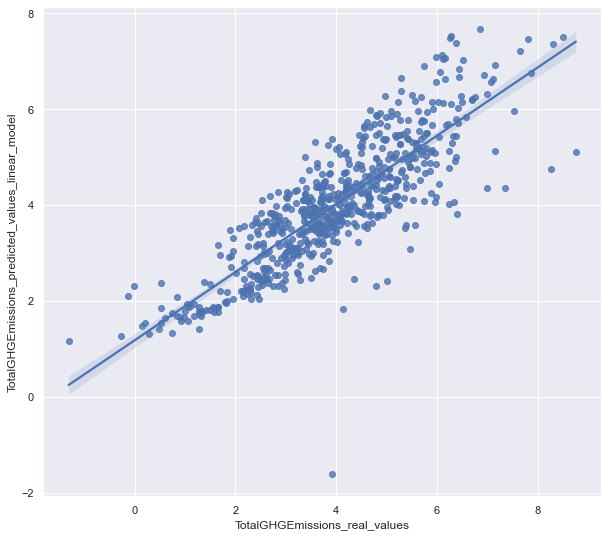

In [613]:
# https://seaborn.pydata.org/tutorial/regression.html

plt.subplots(figsize=(10, 9))
sns.regplot(x="TotalGHGEmissions_real_values", y="TotalGHGEmissions_predicted_values_linear_model", data=real_and_predicted_values_classic_linear_regression_df)

The previous graph shows the linear tendency of correlation between real and predicted values, which suggests that the linear regression model of ordinary least squares has a good level of prediction.

In the next graph, we will show a comparison between real and predicted values, by sorting out the data.

In [614]:
real_and_predicted_values_classic_linear_regression_df = real_and_predicted_values_classic_linear_regression_df.sort_values(by=['TotalGHGEmissions_real_values'])

In [615]:
list_y_GHG_emissions_size = [i for i in range(len(real_and_predicted_values_classic_linear_regression_df))]

In [616]:
real_and_predicted_values_classic_linear_regression_df['x_values_for_visualization'] = list_y_GHG_emissions_size

In [617]:
real_and_predicted_values_classic_linear_regression_df.head()

,TotalGHGEmissions_real_values,TotalGHGEmissions_predicted_values_linear_model,x_values_for_visualization
1306,-1.309333,1.160505,0
1593,-0.261365,1.283370,1
2223,-0.127833,2.108628,2
3048,-0.010050,2.318856,3
1043,0.148420,1.489492,4


<AxesSubplot:xlabel='x_values_for_visualization', ylabel='TotalGHGEmissions_real_values'>

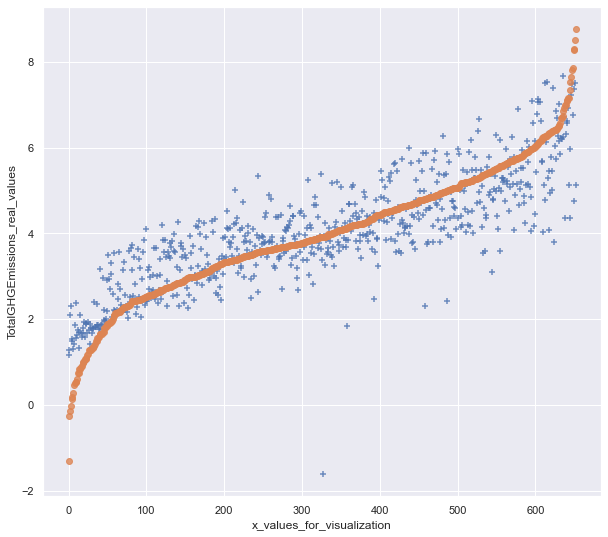

In [618]:
plt.subplots(figsize=(10, 9))
sns.regplot(x="x_values_for_visualization", y="TotalGHGEmissions_predicted_values_linear_model", data=real_and_predicted_values_classic_linear_regression_df, fit_reg=False, marker='+')
sns.regplot(x="x_values_for_visualization", y="TotalGHGEmissions_real_values", data=real_and_predicted_values_classic_linear_regression_df, fit_reg=False)


The previous graph shows how predicted values (blue points) vary from real values (orange points), so that we can visualize the effectiveness of the linear regression model.

As linear regression has no parameters, there is no way to control the complexity of the model. For this, we’ll add regularization.

https://towardsdatascience.com/linear-regression-models-4a3d14b8d368

### Ridge Regression (L2 Regularization)

Ridge regression imposes a penalty on the size of the coefficents. Here we want the magnitude of the coefficients to be minimized so that each feature has as little effect on the outcome as possible. See reference:

https://github.com/terrah27/ml_guides/blob/main/linear_models_regression.ipynb

In [619]:
from sklearn import linear_model
from sklearn.linear_model import Ridge

We start by performing a cross validation for the Ridge regression by following the example in reference: 
https://openclassrooms.com/fr/courses/4297211-evaluez-les-performances-dun-modele-de-machine-learning/4308246-tp-selectionnez-le-nombre-de-voisins-dans-un-knn

Our next goal is to create the parameter grid for searching the hyperparameters of the Ridge regression that are going to be optimized. Then we select the score metric to evaluate the model. We then set the number of folds for the cross validation and we select the model, which in this case is Ridge Regression (L2 Regularization).

In [620]:
# Create the parameter grid based on the results of random search
parameter_grid = {'alpha': [0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]}

# Number of folds of crossed validation
n_cv = 10

# Selects a score to optimize. Here R2.
score = 'r2'

# creates a model
model_selected = linear_model.Ridge()

#### GridSearch implementation and data modelling visualization

We will create a function that will use the "GridSearchCV" method to cross-validate the hyperparameters of a model on the training set. The function will also provide values of the models performance via the R2 score, the prediction errors such as MSE and MAE, and will produce a graph with the representation of the real and predicted values.

In the first case, we will cross-validate the alpha parameter of a Ridge or Lasso Regression.

In [621]:
def create_and_optimize_model(model_selected, parameter_grid, n_cv, score, target_column_real_values, predicted_values_from_model):

    model_optimized_via_grid_search = model_selection.GridSearchCV(
                                model_selected,                     # Model to fit
                                param_grid = parameter_grid,        # Hyperparameters to test
                                cv = n_cv,                          # Number of folds of crossed validation
                                scoring = score                     # score to optimize
                                )

    # Optimizes the Ridge regression with the training data
    model_optimized_via_grid_search.fit(X_training, y_training)

    # # Shows the best optimized hyperparameters
    print("Best hyperparametre in the training data:")
    print(model_optimized_via_grid_search.best_params_)

    # Shows the corresponding performances
    print("Cross validation results:")
    for mean, std, params in zip(
                                model_optimized_via_grid_search.cv_results_['mean_test_score'], # mean score
                                model_optimized_via_grid_search.cv_results_['std_test_score'],  # score standard deviation
                                model_optimized_via_grid_search.cv_results_['params']           # hyperparameter value
                                ):

        print("{} = {:.3f} (+/-{:.03f}) for {}".format(
                                                        score,
                                                        mean,
                                                        std*2,
                                                        params
                                                    ))

    ''' We use the optimized trained model obtained from the cross validation process to compare predicted and real values. 
        We will asign the prediction probabilities values to the variable y_values_pred'''
    # X_test is the set that is going to be passed to the model. Here we calculate prediction probabilities.
    y_values_pred = model_optimized_via_grid_search.predict(X_test)

    '''We will now obtain the score R2 of the regression'''
    print("The coefficient of determination of the prediction of the model, R2, is equal to: {}".format
                                                (model_optimized_via_grid_search.score(X_test, y_test))) 
                                                # y_test corresponds to the known (real) values to predict the target column values

    ''' We can obtain the error loss of the prediction model. For this we will use Mean Square Error (MSE) and Mean Absolute Error (MAE). 
        Consult reference https://www.dataquest.io/blog/understanding-regression-error-metrics/ '''
    print("Mean squared error for the model is: {}".format
                                                (mean_squared_error(y_test, y_values_pred)))
    print("Mean absolute error for the model is: {}".format
                                                (mean_absolute_error(y_test, y_values_pred)))

    '''We create a data frame that will contain the real and predicted values '''
    real_and_predicted_values_df = pd.DataFrame()
    real_and_predicted_values_df[target_column_real_values] = y_test
    real_and_predicted_values_df[predicted_values_from_model] = y_values_pred

    ''' We will now plot the real and the predicted values of the target column from the prediction model'''
    # https://seaborn.pydata.org/tutorial/regression.html
    plt.subplots(figsize=(10, 9))
    sns.regplot(x=target_column_real_values, y=predicted_values_from_model, data=real_and_predicted_values_df)
 
    '''We will plot sorted read and predicted data points for a better visualization and comparison'''
    real_and_predicted_values_df = real_and_predicted_values_df.sort_values(by=[target_column_real_values])
    list_y_size = [i for i in range(len(real_and_predicted_values_df))]
    real_and_predicted_values_df['x_values_for_visualization'] = list_y_size

    plt.subplots(figsize=(10, 9))
    sns.regplot(x='x_values_for_visualization', y=predicted_values_from_model, data=real_and_predicted_values_df, fit_reg=False, marker='+')
    sns.regplot(x='x_values_for_visualization', y=target_column_real_values, data=real_and_predicted_values_df, fit_reg=False)


Best hyperparametre in the training data:
{'alpha': 0.01}
Cross validation results:
r2 = 0.717 (+/-0.087) for {'alpha': 1e-07}
r2 = 0.717 (+/-0.087) for {'alpha': 1e-06}
r2 = 0.717 (+/-0.087) for {'alpha': 1e-05}
r2 = 0.717 (+/-0.087) for {'alpha': 0.0001}
r2 = 0.717 (+/-0.087) for {'alpha': 0.001}
r2 = 0.717 (+/-0.087) for {'alpha': 0.01}
r2 = 0.717 (+/-0.087) for {'alpha': 0.1}
r2 = 0.717 (+/-0.087) for {'alpha': 1}
r2 = 0.716 (+/-0.087) for {'alpha': 10}
The coefficient of determination of the prediction of the model, R2, is equal to: 0.6985790621184964
Mean squared error for the model is: 0.6783918956996672
Mean absolute error for the model is: 0.6115583677080769


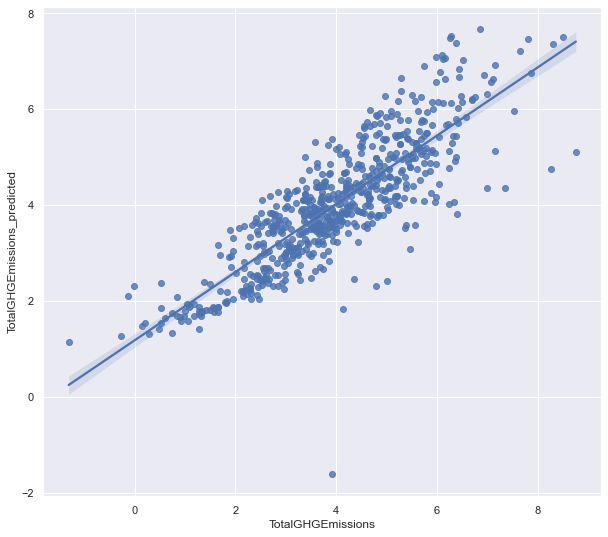

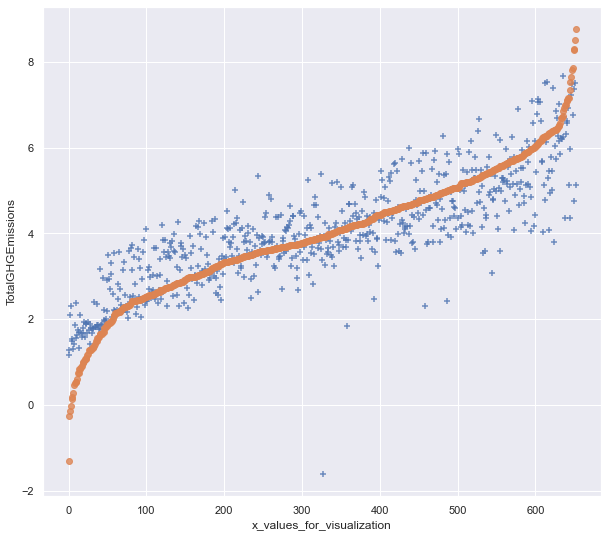

In [622]:
create_and_optimize_model(model_selected, parameter_grid, n_cv, score, 'TotalGHGEmissions', 'TotalGHGEmissions_predicted')

In the previous cell we obtained the best hyperparameters of the linear regression with Ridge regularization, so that we could also train an optimized model and measure its performance on unseen data. Here, the coefficient of determination R2 from Ridge regularization, is close to the value of R2 obtained from Ordinary Least Squares linear regression alone (0.68), and the same occurred with the values of MSE and MAE.

We will apply next a Lasso regularization to see if such penalization improves the results of predictions or if the error loss decreases.

### Lasso Regression (L1 Regularization)

Lasso regression uses L1 regularization to force some coefficents to be exactly zero which means they are ignored by the model. This can be used as a type of feature selection! Lasso can make the model easier to interpret and reveal the most important features.

In [623]:
from sklearn.linear_model import Lasso

from sklearn import linear_model

We will perform a cross validation for the Lasso regression to optimize the hyperparameters and the model, by executing the create_and_optimize_model() function.

We create the parameter grid for searching the hyperparameters of the Lasso regression that are going to be optimized. Then we select the score metric to evaluate the model and the model.

In [624]:
# Create the parameter grid based on the results of random search
parameter_grid = {'alpha': [0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]}

# Number of folds of crossed validation
n_cv = 10

# Selects a score to optimize. Here R2.
score = 'r2'

# creates a model
model_selected = linear_model.Lasso()

Best hyperparametre in the training data:
{'alpha': 1e-07}
Cross validation results:
r2 = 0.717 (+/-0.087) for {'alpha': 1e-07}
r2 = 0.717 (+/-0.087) for {'alpha': 1e-06}
r2 = 0.717 (+/-0.087) for {'alpha': 1e-05}
r2 = 0.717 (+/-0.087) for {'alpha': 0.0001}
r2 = 0.716 (+/-0.087) for {'alpha': 0.001}
r2 = 0.716 (+/-0.088) for {'alpha': 0.01}
r2 = 0.711 (+/-0.088) for {'alpha': 0.1}
r2 = 0.519 (+/-0.053) for {'alpha': 1}
r2 = -0.004 (+/-0.010) for {'alpha': 10}
The coefficient of determination of the prediction of the model, R2, is equal to: 0.6985962968403437
Mean squared error for the model is: 0.6783531064380187
Mean absolute error for the model is: 0.6115506800818773


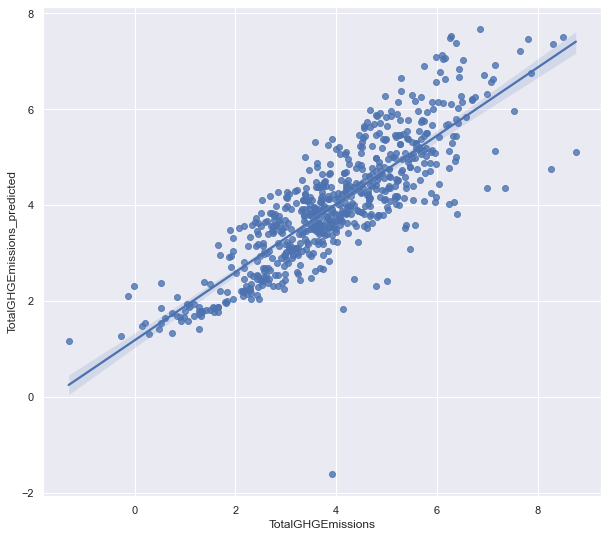

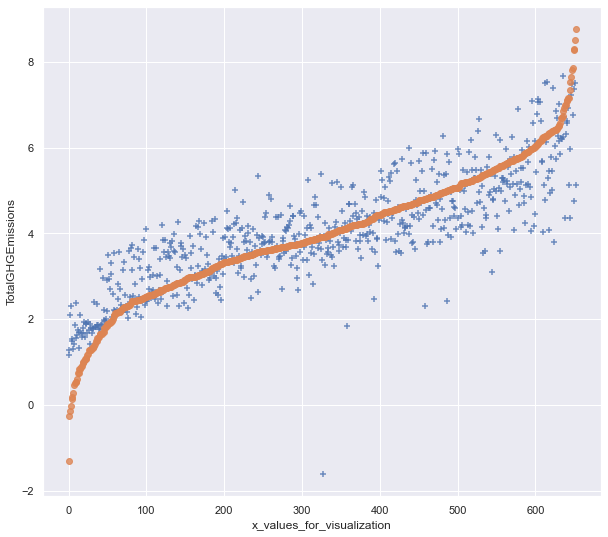

In [625]:
create_and_optimize_model(model_selected, parameter_grid, n_cv, score, 'TotalGHGEmissions', 'TotalGHGEmissions_predicted')

We now obtained the best hyperparameters of the linear regression with Lasso regularization. We also trained an optimized model and measured its performance on unseen data. 
This time, the coefficient of determination R2 (0.68) resulted slighly different than the one obtained from Ridge regularization (0.69) and Ordinary Least Squares linear regression alone (0.68). With the Lasso regularization, we did not observe significative differences from the MSE and MAE values obtained with Ridge and no-regularization.


For this reason, we will evaluate the performance of a random forest regressor model.

### Analysis using a random forest regressor

We import the model of random forest for regression.

In [626]:
from sklearn import model_selection

from sklearn.ensemble import RandomForestRegressor

In [627]:
#define cross-validation method to use
cv = KFold(n_splits=10, random_state=1, shuffle=True)

#build multiple linear regression model
rf_reg = RandomForestRegressor()

#use k-fold CV to evaluate model
scores = cross_val_score(rf_reg, X_training, y_training, scoring='r2', cv=cv)

In [628]:
#view mean absolute error
print('Array of R2 for each k-fold: ', scores)
print('mean R2: ', np.mean(scores))
print('R2 std: ', np.std(scores))

Array of R2 for each k-fold:  [0.93206961 0.95048984 0.95383591 0.97705502 0.96421623 0.94704292
 0.96760689 0.94049602 0.94662659 0.9465557 ]
mean R2:  0.9525994736965775
R2 std:  0.012787771988466971


From the above result, we observe that the performance of the random forest regressor is superior to that of the linear ordinary least squares regression and the Ridge and Lasso regularization.

We can create now the parameter grid for searching the hyperparameters of the random forest regressor that are going to be optimized. Then we select the score metric to evaluate the model. In this case, R2. See reference:

https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

https://odsc.medium.com/optimizing-hyperparameters-for-random-forest-algorithms-in-scikit-learn-d60b7aa07ead

In [629]:
# Create the parameter grid based on the results of random search
parameter_grid = {
            'max_depth': [5,10,20],
            'n_estimators': [20,50,100]
}

# Number of folds of crossed validation
n_cv = 10

# Selects a score to optimize. Here R2.
score = 'r2'

# creates a model
model_selected = RandomForestRegressor()

Best hyperparametre in the training data:
{'max_depth': 20, 'n_estimators': 50}
Cross validation results:
r2 = 0.914 (+/-0.038) for {'max_depth': 5, 'n_estimators': 20}
r2 = 0.917 (+/-0.033) for {'max_depth': 5, 'n_estimators': 50}
r2 = 0.916 (+/-0.037) for {'max_depth': 5, 'n_estimators': 100}
r2 = 0.952 (+/-0.024) for {'max_depth': 10, 'n_estimators': 20}
r2 = 0.953 (+/-0.026) for {'max_depth': 10, 'n_estimators': 50}
r2 = 0.953 (+/-0.028) for {'max_depth': 10, 'n_estimators': 100}
r2 = 0.952 (+/-0.030) for {'max_depth': 20, 'n_estimators': 20}
r2 = 0.954 (+/-0.028) for {'max_depth': 20, 'n_estimators': 50}
r2 = 0.953 (+/-0.027) for {'max_depth': 20, 'n_estimators': 100}
The coefficient of determination of the prediction of the model, R2, is equal to: 0.9602971211315213
Mean squared error for the model is: 0.08935713441018488
Mean absolute error for the model is: 0.11419296368890772


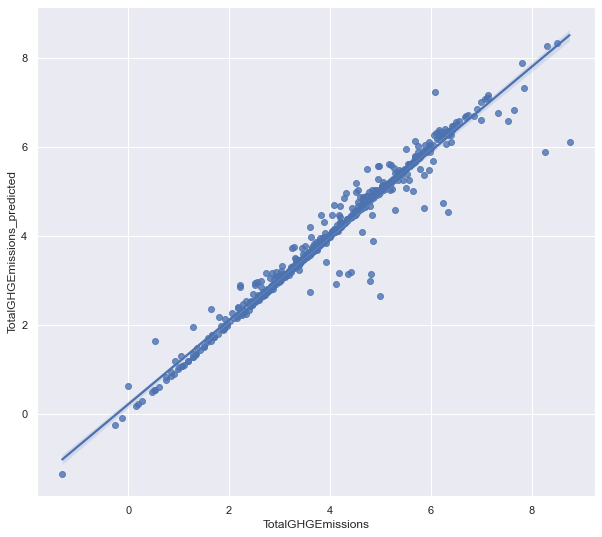

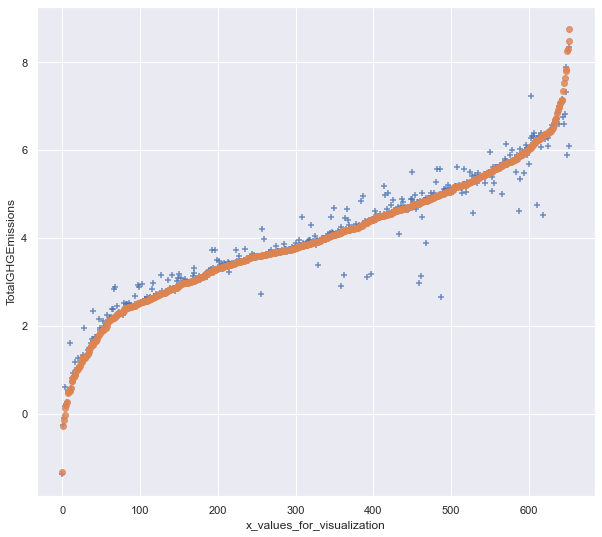

In [630]:
create_and_optimize_model(model_selected, parameter_grid, n_cv, score, 'TotalGHGEmissions', 'TotalGHGEmissions_predicted')

The higher value of the coefficient of determination R2 of the random forest regressor and the decrease of error losses in the unseen data, indicate that we can use this model to predict the variables of interest for the project mission.

So far we have tested our model with one of the variables of interest, which is the Green House Gas emissions. Next, we will apply the random forest regressor to make predictions about the property energy consumption.

#### Prediction of energy consumption using random forest regressor

In [631]:
X_training, y_training, X_test, y_test = get_training_and_testing_data(df_log_transformed, 'SiteEnergyUse(kBtu)')

In [632]:
# Create the parameter grid based on the results of random search
parameter_grid = {
            'max_depth': [5,10,20],
            'n_estimators': [20,50,100]
}

# Number of folds of crossed validation
n_cv = 10

# Selects a score to optimize. Here R2.
score = 'r2'

# creates a model
model_selected = RandomForestRegressor()

Best hyperparametre in the training data:
{'max_depth': 5, 'n_estimators': 20}
Cross validation results:
r2 = 0.721 (+/-0.379) for {'max_depth': 5, 'n_estimators': 20}
r2 = 0.719 (+/-0.411) for {'max_depth': 5, 'n_estimators': 50}
r2 = 0.718 (+/-0.408) for {'max_depth': 5, 'n_estimators': 100}
r2 = 0.645 (+/-0.334) for {'max_depth': 10, 'n_estimators': 20}
r2 = 0.650 (+/-0.301) for {'max_depth': 10, 'n_estimators': 50}
r2 = 0.628 (+/-0.308) for {'max_depth': 10, 'n_estimators': 100}
r2 = 0.600 (+/-0.349) for {'max_depth': 20, 'n_estimators': 20}
r2 = 0.624 (+/-0.347) for {'max_depth': 20, 'n_estimators': 50}
r2 = 0.614 (+/-0.298) for {'max_depth': 20, 'n_estimators': 100}
The coefficient of determination of the prediction of the model, R2, is equal to: 0.9560544868044873
Mean squared error for the model is: 0.09567423354432689
Mean absolute error for the model is: 0.2001078630851917


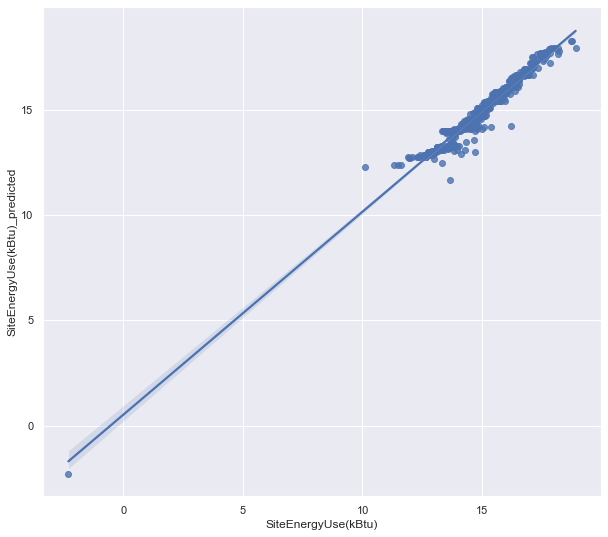

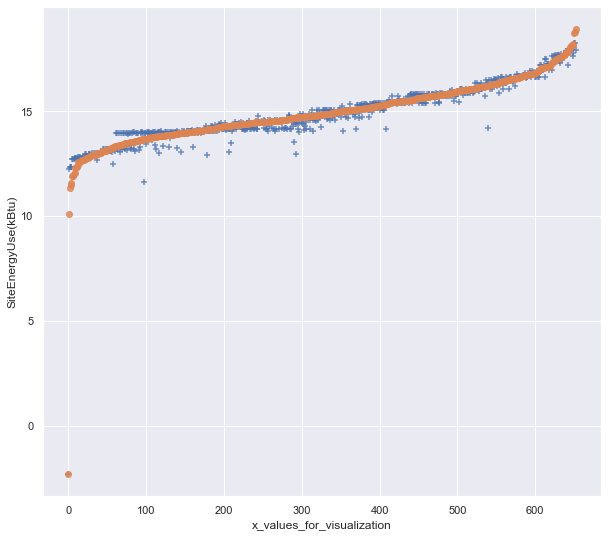

In [633]:
create_and_optimize_model(model_selected, parameter_grid, n_cv, score, 'SiteEnergyUse(kBtu)', 'SiteEnergyUse(kBtu)_predicted')

From the previous result, we observe that as expected, the predicted values obtained from the random forest regressor are highly close to the real values, representing a good choice for data modelling.